In [41]:
#I made the workflow in a little notebook so the parameters are all here and its traceable.
#If you want to play around with it, it'll prob take some time since getting everything installed
#and woprking is a pain


In [ ]:
import subprocess
import shlex

def runHHblits( aln , name, path , outdir, db , iterations , ncores , runName='' , SS= False  , ohhm = False , verbose = True , Z = 2000 , B = 2000 , xargs = ' -cons '):
    if verbose == True:
        print( [aln , name, path , outdir, db , iterations , ncores , runName] )
    
    outhhr= outdir+name+runName+".hhr"
    args = path + ' -cpu '+ str(ncores) +' -d ' + db + ' -i ' + aln  +' -o '+ outhhr + ' -n ' + str(iterations) + ' -B '+ str(B) + ' -Z ' + str(Z) +' '+ xargs 
    if SS == True:
         args += ' -ssm 2 -ssw .5 '
    
    if ohhm == True:
        outa3m = outdir+name+runName+'.a3m'
        args += ' -Oa3m ' + outa3m
    else: 
        outa3m = None
    if verbose == True:
        print(args)
    
    args = shlex.split( args)
    p = subprocess.run( args )
    return p , [outhhr,outa3m]

In [2]:
#run hhblits
p, outfiles = runHHblits( './HOG25968.1.aln' , 'HOG25968' , 'hhblits', outdir = './' , db ='/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70' , ohhm = True,  iterations = 1 , ncores = 8 , )
print(outfiles)


['./HOG25968.1.aln', 'HOG25968', 'hhblits', './', '/home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70', 1, 8, '']
hhblits -cpu 8 -d /home/cactuskid13/mntpt/HHBLITsdb/pdb70/pdb70 -i ./HOG25968.1.aln -o ./HOG25968.hhr -n 1 -B 2000 -Z 2000  -cons  -Oa3m ./HOG25968.a3m
['./HOG25968.hhr', './HOG25968.a3m']


In [1]:
#parse results

import csb
import pandas as pd 

from csb.bio.io.hhpred import HHOutputParser
results = HHOutputParser(alignments=False).parse_file('./HOG25968.hhr')

newhits = {}
hitlist=[]
for hit in results:
    hitlist.append(hit.id)
    newhits.update( {  hit.id : { 'prob':hit.probability, 'len' : hit.length , 'score': hit.score   , 'start':hit.start , 'stop':hit.end }}  )
      
hhdf = pd.DataFrame.from_dict(newhits, orient = 'index')
hhdf['model'] = hhdf.index.map(lambda x : x.split('_')[0])
hhdf['chain'] = hhdf.index.map(lambda x : x.split('_')[1])

print(hhdf.head())



         prob  len  score  start  stop model chain
1A77_A  0.994  182  165.6      1   182  1A77     A
1B43_B  0.995  181  178.8      1   181  1B43     B
1BGX_T  0.985  146  136.1      5   150  1BGX     T
1CMW_A  0.987  144  140.9      8   151  1CMW     A
1HUX_B  0.980  230   95.5      2   231  1HUX     B


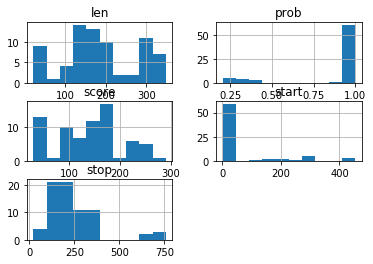

structure subset


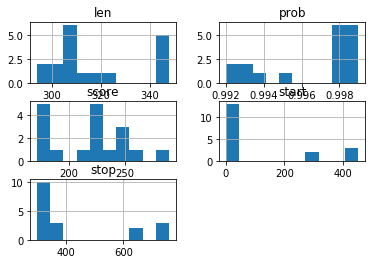

         prob  len  score  start  stop model chain
2IVN_A  0.998  307  226.2      2   308  2IVN     A
2IVP_A  0.998  307  226.2      2   308  2IVP     A
2VWB_A  0.999  299  248.9      2   300  2VWB     A
3EN9_A  0.999  301  245.3      5   305  3EN9     A
3ENO_A  0.998  309  221.5      3   311  3ENO     A
3ENO_B  0.998  309  221.5      3   311  3ENO     B
3TTC_A  0.994  347  180.5    303   649  3TTC     A
3TTD_A  0.992  347  171.9    303   649  3TTD     A
3VEN_A  0.995  346  190.2     12   357  3VEN     A
3VTH_A  0.992  294  171.2    453   746  3VTH     A
3WUH_B  0.999  348  255.2      6   353  3WUH     B
3ZEU_B  0.998  322  214.2      2   323  3ZEU     B
4G9I_A  0.993  307  179.7    452   758  4G9I     A
4G9I_F  0.993  307  179.7    452   758  4G9I     F
4K25_A  0.999  348  251.8      6   353  4K25     A
5JMV_A  0.999  302  289.6      4   305  5JMV     A
6GWJ_K  0.999  313  239.6      1   313  6GWJ     K
6N9A_D  0.998  318  226.9      2   319  6N9A     D


In [2]:
#select best candidates
from matplotlib import pyplot as plt
hhdf.hist()
plt.show()
print('structure subset')
sub = hhdf[hhdf.prob> .97]
sub = sub[sub.len > 200 ]
sub = sub[sub.score > 120 ]
sub.hist()
plt.show()

chains= dict( zip ( sub.model, sub.chain ))

print(sub)

In [3]:
#now we have some long high quality hits to some chains
#get templates
import wget
import glob

dl_url = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
for m in sub.model.unique():
    print(m)
    structfile = './templates/'+m.upper()+'.pdb'
    structs[m]= structfile
    if structfile not in already:
        wget.download(url = dl_url + m +'.pdb' , out =structfile)

2IVN
2IVP
2VWB
3EN9
3ENO
3TTC
3TTD
3VEN
3VTH
3WUH
3ZEU
4G9I
4K25
5JMV
6GWJ
6N9A


In [4]:
from Bio.PDB import *
#find ca string for each strucutre
#make sure you grab the right chain
from Bio import Alphabet
parser = PDBParser()
from Bio.SeqUtils import seq1

letter3 = Alphabet.ThreeLetterProtein.letters
converter = { l.upper(): seq1(l) for l in letter3} 
print(converter)

{'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W', 'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}


In [23]:
models = {}
ali_input = {}
builder = Polypeptide.PPBuilder()
#slice structures in hhr
for idx,row in sub.iterrows():
    code = row.model
    if code in structs:
        structure = parser.get_structure(code,structs[code])
        for chain in structure.get_chains():
            if chain.id == row.chain:
                #trim the structures to hhblits detected regions
                Dice.extract(structure=structure , chain_id=chain.id , start=row.start-1, end=row.stop , filename='./modellercif/'+row.model+'.pdb' )
                sub_structure = parser.get_structure(code , './modellercif/'+row.model+'.pdb' )
                
                #mdl = model(env, file='./modellercif/'+row.model+'.pdb', model_segment=('FIRST:'+chain.id, 'LAST:'+chain.id))
                #chains = mdl.make_chains(file='./modellercif/'+row.model+'.pdb')
                
                subchains = [ c for c in structure.get_chains()]
                peptides  = [p for p in  builder.build_peptides(subchains[0])]
                pp = peptides[0]
                gaps = 0 
                seq = str(pp.get_sequence())
                #for i,pp in enumerate(peptides):
                #    if i > 0:
                #        seq+='-'
                #    seq += str(pp.get_sequence())
                #ali_input[row.model] = { 'chain': subchains[0].id , 'seq': seq , 'start':'' , 'stop':''  }     
                models[row.model]={'mdl': './modellercif/'+row.model+'.pdb' , 'chain':subchains[0].id }
                # grab all sequences from the query input

from Bio import SeqIO
for seq in SeqIO.parse('HOG25968.fa' , 'fasta'):
    ali_input[seq.id] = { 'chain': '', 'seq': str(seq.seq) , 'start':1 , 'stop':len(seq.seq)  } 
alidf = pd.DataFrame.from_dict( ali_input , orient = 'index')
print(alidf)

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 8764.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 8795.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17054.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 17056.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 17076.
  P

                                                   chain  \
CCD75246.1                                                 
CCD81830.1                                                 
CCD81832.1                                                 
KGB38596.1                                                 
KGB38598.1                                                 
KGB42289.1                                                 
OON17875.1                                                 
RJW69012.1                                                 
RTG80244.1                                                 
RTG82576.1                                                 
RTG89369.1                                                 
TGZ56992.1                                                 
TGZ56993.1                                                 
THD25851.1                                                 
TNN07835.1                                                 
TNN07836.1                              

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11593.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11631.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 11739.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 11803.
  PDBConstructionWarning)
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:91: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 11885.
 

In [35]:
from modeller import *
import modeller.salign
log.none()
env = environ()
env.io.atom_files_directory = ['./modellercif/']

#aln = alignment(env, file='align2d_in.ali', align_codes='all' )
aln = alignment(env)
print(aln)
knowns = []
for m in models:
    try:
        mdl = model(env, file=m, model_segment=('FIRST:'+models[m]['chain'], 'LAST:'+models[m]['chain']))
        aln.append_model(mdl, atom_files=m, align_codes= m)
        knowns.append(m)
    except:
        print(m)

for (weights, write_fit, whole) in (((1., 0., 0., 0., 1., 0.), False, True),
                            ((1., 0.5, 1., 1., 1., 0.), False, True),
                            ((1., 1., 1., 1., 1., 0.), True, False)):
    aln.salign(rms_cutoff=3.5, normalize_pp_scores=False,
       rr_file='$(LIB)/as1.sim.mat', overhang=30,
       gap_penalties_1d=(-450, -50),
       gap_penalties_3d=(0, 3), gap_gap_score=0, gap_residue_score=0,
       dendrogram_file='1is3A.tree',
       alignment_type='tree',
       feature_weights=weights, # For a multiple sequence alignment only
       improve_alignment=True, fit=True, write_fit=write_fit,
       write_whole_pdb=whole, output='ALIGNMENT QUALITY')

aln.write(file='1is3A-it.pap', alignment_format='PAP')
aln.write(file='1is3A-it.ali', alignment_format='PIR')

print('DONE')

<Empty alignment>
3ENO
3WUH
3ZEU
4G9I
6GWJ
6N9A
DONE


In [36]:
blockct = 0
print('making sequence pir')
with open( 'align2d_in.ali' , 'w') as alnout:
    for idx,row in alidf.iterrows():
        print(row)
        if len(row.chain ) > 0:
            pass
        #    line2 = 'structureX:'+idx+':'+str(row.start)+' :'+row.chain + ':' + str( row.stop  )  + ':::::'+'\n'
        else:
            blockct+=1
            print(idx)
            line1 = '>P1;'+idx +'\n'
            line2 = 'sequence:'+idx+':1 : :'+str( len(row.seq) )  + ':::::' +'\n' 
            line3 = row.seq +'*\n'
            #print(  line1 + line2 + line3)
            alnout.write( line1 + line2 + line3)
            
print('aln struct block to seq block ')   
#structure sensitive aln
aln = alignment(env, file='align2d_in.ali', align_codes='all' )
aln.append(file='1is3A-it.ali', align_codes='all')
aln.salign(
               align_block= blockct,
               gap_penalties_1d=(-100, 0),
               gap_penalties_2d=(3.5, 3.5, 3.5, 0.2, 4.0, 6.5, 2.0, 0.0, 0.0),
            fit = True
               # d.p. score matrix
               #output_weights_file='salign.mtx'
               )
aln.write(file='align2d.pap', alignment_format='PAP',
          alignment_features='INDICES HELIX BETA STRAIGHTNESS ' + \
                             'ACCESSIBILITY CONSERVATION')

#output aln
aln.write(file='align2d_all.ali', alignment_format='PIR')
print('DONE')

making sequence pir
chain                                                     
seq      MGIRGLWTYIQSNSENFSPYELHNQPLVIDAENFASLCYRQATLRC...
start                                                    1
stop                                                   725
Name: CCD75246.1, dtype: object
CCD75246.1
chain                                                     
seq      MLPLFAILVGNDMISNIRLPTVIDSLMCTSVLQSRSHYQRRIDAIF...
start                                                    1
stop                                                   492
Name: CCD81830.1, dtype: object
CCD81830.1
chain                                                     
seq      MGIRGLWTYIQSNSDNLSRYELHNQPLVIDAENFAAFCYRRAAFRC...
start                                                    1
stop                                                   722
Name: CCD81832.1, dtype: object
CCD81832.1
chain                                                     
seq      MVFKITERAMRHCGVNVKEMGIRGLWTYIESSGGNLSVYELHNQPL...
start                    

In [38]:
#run modeller
print(models)

# Comparative modeling by the automodel class
from modeller import *              # Load standard Modeller classes
from modeller.automodel import *    # Load the automodel class
print(knowns)
env = environ() 
env.io.atom_files_directory = ['./modellercif/']

a = automodel(env,
              alnfile  = 'align2d_all.ali',     # alignment filename
              knowns   =  knowns ,              # codes of the templates
              sequence =  "snap_masked-jcf7180000239893-processed-gene-0.3-mRNA-1")              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do the actual comparative modeling


{'2IVN': {'mdl': './modellercif/2IVN.pdb', 'chain': 'A'}, '2IVP': {'mdl': './modellercif/2IVP.pdb', 'chain': 'A'}, '2VWB': {'mdl': './modellercif/2VWB.pdb', 'chain': 'A'}, '3EN9': {'mdl': './modellercif/3EN9.pdb', 'chain': 'A'}, '3ENO': {'mdl': './modellercif/3ENO.pdb', 'chain': 'A'}, '3TTC': {'mdl': './modellercif/3TTC.pdb', 'chain': 'A'}, '3TTD': {'mdl': './modellercif/3TTD.pdb', 'chain': 'A'}, '3VEN': {'mdl': './modellercif/3VEN.pdb', 'chain': 'A'}, '3VTH': {'mdl': './modellercif/3VTH.pdb', 'chain': 'A'}, '3WUH': {'mdl': './modellercif/3WUH.pdb', 'chain': 'A'}, '3ZEU': {'mdl': './modellercif/3ZEU.pdb', 'chain': 'A'}, '4G9I': {'mdl': './modellercif/4G9I.pdb', 'chain': 'A'}, '4K25': {'mdl': './modellercif/4K25.pdb', 'chain': 'A'}, '5JMV': {'mdl': './modellercif/5JMV.pdb', 'chain': 'A'}, '6GWJ': {'mdl': './modellercif/6GWJ.pdb', 'chain': 'B'}, '6N9A': {'mdl': './modellercif/6N9A.pdb', 'chain': 'B'}}
['2IVN', '2IVP', '2VWB', '3EN9', '3TTC', '3TTD', '3VEN', '3VTH', '4K25', '5JMV']
openf_